In [ ]:
!pip install tensorflow
!pip install numpy
!pip install tqdm
!pip install matplotlib

In [151]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# MNIST 손글씨 데이터 다운로드
데이터 다운로드에만 tensorflow 사용

In [170]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images, test_images = train_images / 255.0,  test_images / 255.0

print("train_images.shape", train_images.shape)
print("train_labels.shape", train_labels.shape)
print("test_images.shape", test_images.shape)
print("test_labels.shape", test_labels.shape)

train_images.shape (60000, 28, 28)
train_labels.shape (60000,)
test_images.shape (10000, 28, 28)
test_labels.shape (10000,)


# 하이퍼파라미터 설정

In [153]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 2

# Convolution Layer
![Conv2d.png](Conv2d.png)

합성곱 연산

필터(filter) = 커널(kernel)

kernel_size가 5 라는 것은, 5 x 5 필터

필터의 각각의 칸에 가중치(weight)가 있다.


In [154]:
class Conv2d:
  def __init__(self, in_channels, out_channels, kernel_size):
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    # weights 초기화
    self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size)
    # 그래디언트 초기화
    self.grad_weights = np.zeros_like(self.weights)

  def forward(self, x):
    self.x = x
    batch_size, in_channels, height, width = x.shape
    # output 초기화
    out_height = height - self.kernel_size + 1
    out_width = width - self.kernel_size + 1
    self.output = np.zeros((batch_size, self.out_channels, out_height, out_width))
    # convolution 수행
    for b in range(batch_size):
      for c_out in range(self.out_channels):
        for i in range(out_height):
          for j in range(out_width):
            # receptive_filed는 input에서 필터를 적용할 범위
            receptive_field = x[b, :, i:i+self.kernel_size, j:j+self.kernel_size]
            # receptive_field의 각 칸과 weights 필터의 각 칸의 곱들을 모두 더해서 output 칸에 넣는다
            self.output[b, c_out, i, j] = np.sum(receptive_field * self.weights[c_out])
    return self.output

  def backward(self, grad_output, learning_rate=0.01):
    batch_size, out_channels, out_height, out_width = grad_output.shape
    # gradients 초기화
    grad_weights = np.zeros_like(self.weights)
    grad_input = np.zeros_like(self.x)
    # gradients 계산
    for b in range(batch_size):
      for c_out in range(self.out_channels):
        for i in range(out_height):
          for j in range(out_width):
            receptive_field = self.x[b, :, i:i+self.kernel_size, j:j+self.kernel_size]
            grad_weights[c_out] += grad_output[b, c_out, i, j] * receptive_field
            grad_input[b, :, i:i+self.kernel_size, j:j+self.kernel_size] += grad_output[b, c_out, i, j] * self.weights[c_out]
    # weights 업데이트
    self.weights -= learning_rate * grad_weights
    return grad_input

  def zero_grad(self):
    # 그래디언트 초기화
    self.grad_weights.fill(0)

# ReLU Layer
![ReLU.png](ReLU.png)

활성화 함수.

0 이하의 값이 들어오면 0으로, 그 이상의 값이 들어오면 값을 그대로 전달한다.

y = x 를 미분하면 1이 나오기 때문에 기울기 값이 그대로 전파되므로 학습 속도가 빠르다.

지수 연산이 들어가지 않고 값을 그대로 전달해주기 때문에 연산 속도가 빠르다.

In [155]:
class ReLU:
  def __init__(self):
    self.input = None

  def forward(self, x):
    self.input = x
    return np.maximum(0, x)

  def backward(self, grad_output, learning_rate=None):
    # input이 0보다 컸던 칸은 grad_output을 그대로 전달, 아닌 칸은 0을 전달
    grad_input = np.where(self.input > 0, grad_output, 0)
    return grad_input

# MaxPool2d Layer
![MaxPool2d.png](MaxPool2d.png)

맥스 풀링

일정 크기의 구간 내에서 가장 큰 값만을 전달하고 다른 정보는 버린다.

kernel_size가 2면 풀링을 적용하는 범위를 2x2로 잡은 것.

stride가 2면 한 번에 2칸씩 이동하는 것.

In [156]:
class MaxPool2d:
  def __init__(self, kernel_size, stride):
    self.kernel_size = kernel_size
    self.stride = stride
    self.input = None
    self.argmax = None

  def forward(self, x):
    self.input = x
    batch_size, in_channels, height, width = x.shape
    # output 초기화
    out_height = (height - self.kernel_size) // self.stride + 1
    out_width = (width - self.kernel_size) // self.stride + 1

    self.argmax = np.zeros((batch_size, in_channels, out_height, out_width, 2), dtype=int)
    self.output = np.zeros((batch_size, in_channels, out_height, out_width))

    for b in range(batch_size):
      for c in range(in_channels):
        for i in range(out_height):
          for j in range(out_width):
            # receptive_filed는 input에서 풀링을 적용할 범위
            receptive_field = x[b, c, i * self.stride:i * self.stride + self.kernel_size, j * self.stride:j * self.stride + self.kernel_size]
            # 최댓값과 그 위치를 기록
            # 역전파를 위해 self.argmax를 기록해야한다
            max_value = np.max(receptive_field)
            max_index = np.unravel_index(np.argmax(receptive_field), receptive_field.shape)
            self.output[b, c, i, j] = max_value
            self.argmax[b, c, i, j] = (max_index[0] + i * self.stride, max_index[1] + j * self.stride)
    return self.output

  def backward(self, grad_output, learning_rate=0.01):
    batch_size, in_channels, out_height, out_width = grad_output.shape
    grad_input = np.zeros_like(self.input)
    for b in range(batch_size):
      for c in range(in_channels):
        for i in range(out_height):
          for j in range(out_width):
            grad_input[b, c, self.argmax[b, c, i, j, 0], self.argmax[b, c, i, j, 1]] = grad_output[b, c, i, j]
    return grad_input

# Fully Connected Layer
완전 연결 레이어

[채널,가로,세로] 데이터를 한줄로 쭉 핀다.

 LinearLayer 통과하면서, 가중치와 곱하면서 벡터 크기를 줄인다.

In [157]:
class Linear:
  def __init__(self, in_features, out_features):
    self.in_features = in_features
    self.out_features = out_features
    # weights 초기화
    self.weights = np.random.randn(out_features, in_features)
    # 그래디언트 초기화
    self.grad_weights = np.zeros_like(self.weights)

  def forward(self, x):
    self.x = x
    # 행렬 곱셈
    self.output = np.dot(x, self.weights.T)
    return self.output

  def backward(self, grad_output, learning_rate=0.01):
    # 입력에 대한 그래디언트 계산
    grad_input = np.dot(grad_output, self.weights)
    # 가중치에 대한 그래디언트 계산
    grad_weights = np.dot(grad_output.T, self.x)
    # weights 업데이트
    self.weights -= learning_rate * grad_weights
    return grad_input

  def zero_grad(self):
    # 그래디언트 초기화
    self.grad_weights.fill(0)


# CNN
Convolution Neural Network

위 layer들을 CNN class 안에 리스트 형태로 넣는다.

반복문을 통해 각 층의 forward, backward로 값을 전파한다.

In [158]:
class CNN:
  def __init__(self):
    # Convolutional layers
    self.conv_layers = [
      Conv2d(in_channels=1, out_channels=1, kernel_size=5), # [batch_size,in_channels,28,28] -> [batch_size,out_channels,24,24]
      ReLU(),
      Conv2d(in_channels=1, out_channels=1, kernel_size=5), # [batch_size,in_channels,24,24] -> [batch_size,out_channels,20,20]
      ReLU(),
      MaxPool2d(kernel_size=2, stride=2),                   # [batch_size,in_channels,20,20] -> [batch_size,out_channels,10,10]
      Conv2d(in_channels=1, out_channels=1, kernel_size=5), # [batch_size,in_channels,10,10] -> [batch_size,out_channels,6,6]
      ReLU(),
      MaxPool2d(kernel_size=2, stride=2)                    # [batch_size,in_channels,6,6] -> [batch_size,out_channels,3,3]
    ]
    # Fully connected layers
    self.fc_layers = [
        Linear(in_features=1*3*3, out_features=100),        # [batch_size,channels*3*3] -> [batch_size,out_features]
        ReLU(),
        Linear(in_features=100, out_features=10)            # [batch_size,in_features] -> [batch_size,out_features]
    ]

  def forward(self, x):
    for layer in self.conv_layers:
      x = layer.forward(x)
    # [채널,가로,세로] 데이터를 한줄로 쭉 핀다.
    x = x.reshape(x.shape[0], -1)                           # [batch_size,channels,3,3] -> [batch_size,channels*3*3]
    for layer in self.fc_layers:
      x = layer.forward(x)
    return x

  def backward(self, grad_output, learning_rate=0.01):
    for layer in reversed(self.fc_layers):
      grad_output = layer.backward(grad_output, learning_rate)
    # 한줄로 있는 데이터를 [채널, 가로, 세로] 모양으로
    grad_output = grad_output.reshape(grad_output.shape[0], 1, 3, 3)  # [batch_size,channels*3*3] -> [batch_size,channels,3,3
    for layer in reversed(self.conv_layers):
      grad_output = layer.backward(grad_output, learning_rate)

  def parameters(self, fc_only=False):
    params = []
    for layer in self.fc_layers if fc_only else self.conv_layers:
      if isinstance(layer, Linear):
        params.extend(layer.weights.flatten())
    return params

  def zero_grad(self):
        for layer in self.fc_layers + self.conv_layers:
            if hasattr(layer, 'zero_grad'):
                layer.zero_grad()

# 교차 엔트로피 손실 함수
forward에서는 결과값과 타겟값을 이용해 오차 확률분포를 구한다.

In [159]:
class CrossEntropyLoss:
  def __init__(self):
    self.softmax_output = None
    self.target = None

  def forward(self, predictions, targets):
    self.target = targets
    exp_predictions = np.exp(predictions - np.max(predictions, axis=1, keepdims=True))
    self.softmax_output = exp_predictions / np.sum(exp_predictions, axis=1, keepdims=True)
    batch_size = predictions.shape[0]
    loss = -np.sum(np.log(self.softmax_output[np.arange(batch_size), targets] + 1e-15)) / batch_size
    return loss

  def backward(self):
    batch_size = self.softmax_output.shape[0]
    grad_input = self.softmax_output.copy()
    grad_input[np.arange(batch_size), self.target] -= 1
    grad_input /= batch_size
    return grad_input

# 최적화 함수 Adam

In [160]:
class AdamOptimizer:
  def __init__(self, parameters, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    self.parameters = parameters
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon

    # 초기값 설정
    self.t = 0
    self.m = [np.zeros_like(param.weights) for param in parameters]
    self.v = [np.zeros_like(param.weights) for param in parameters]

  def step(self):
    self.t += 1
    for i, param in enumerate(self.parameters):
      grad = param.grad_weights
      self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
      self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
      m_hat = self.m[i] / (1 - self.beta1 ** self.t)
      v_hat = self.v[i] / (1 - self.beta2 ** self.t)
      param.weights -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

  def zero_grad(self):
    for param in self.parameters:
      param.zero_grad()

# CNN모델, 오차함수, 최적화함수 세팅

In [162]:
model = CNN()
loss_func = CrossEntropyLoss()
p = []
for layer in model.fc_layers + model.conv_layers:
  if hasattr(layer, 'zero_grad'):
    p.append(layer)
optimizer = AdamOptimizer(parameters=p, learning_rate=0.001)

# 학습
256 * 200 개(60000보다 작게)의 이미지, 모두 1개의 채널로 학습 시킬 때, google colab 기준 약 30분 소요

In [165]:
train_images = train_images[:batch_size*200]
train_labels = train_labels[:batch_size*200]

In [166]:
loss_arr = []
# 학습 반복 횟수
for epoch in range(num_epoch):
  print('epoch : ', epoch+1, '/', num_epoch)
  for j in tqdm(range(0, len(train_images), batch_size)): # tqdm은 진행도 출력
    x = train_images[j:j+batch_size].reshape(batch_size, 1, 28, 28)
    y = train_labels[j:j+batch_size]

    optimizer.zero_grad()
    output = model.forward(x)           # 순전파
    loss = loss_func.forward(output, y) # 오차 구하기
    loss_arr.append(loss)

    grad_output = loss_func.backward()  # 역전파
    model.backward(grad_output)         # 역전파
    optimizer.step()

epoch :  1 / 2


100%|██████████| 200/200 [16:19<00:00,  4.90s/it]


epoch :  2 / 2


100%|██████████| 200/200 [15:44<00:00,  4.72s/it]


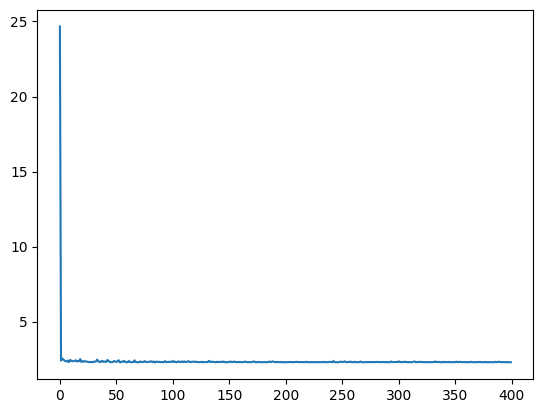

In [167]:
plt.plot(loss_arr)
plt.show()

# 테스트

In [171]:
test_images = test_images[:batch_size*35]
test_labels = test_labels[:batch_size*35]

In [172]:
correct = 0
total = 0

for j in tqdm(range(0, len(test_images), batch_size)):
    x = test_images[j:j + batch_size].reshape(batch_size, 1, 28, 28)
    y = test_labels[j:j + batch_size]

    output = model.forward(x)
    output_index = np.argmax(output, axis=1)

    print('\n', output_index)

    total += y.shape[0]
    correct += np.sum(output_index == y)

  3%|▎         | 1/35 [00:02<01:23,  2.46s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  6%|▌         | 2/35 [00:05<01:40,  3.06s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]


  9%|▊         | 3/35 [00:07<01:21,  2.56s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 11%|█▏        | 4/35 [00:09<01:11,  2.30s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 7 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 14%|█▍        | 5/35 [00:12<01:15,  2.52s/it]


 [0 0 4 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 7 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 17%|█▋        | 6/35 [00:15<01:14,  2.57s/it]


 [0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]


 20%|██        | 7/35 [00:17<01:06,  2.38s/it]


 [0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4]


 23%|██▎       | 8/35 [00:19<01:00,  2.25s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 26%|██▌       | 9/35 [00:21<00:58,  2.26s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 29%|██▊       | 10/35 [00:24<00:58,  2.34s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 2 0 0 0 0 0 0]


 31%|███▏      | 11/35 [00:28<01:08,  2.86s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 7 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 34%|███▍      | 12/35 [00:30<01:05,  2.83s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0
 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 37%|███▋      | 13/35 [00:33<00:58,  2.67s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 7 0 0 0 2]


 40%|████      | 14/35 [00:35<00:55,  2.63s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 43%|████▎     | 15/35 [00:38<00:53,  2.66s/it]


 [0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 46%|████▌     | 16/35 [00:43<01:01,  3.24s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 49%|████▊     | 17/35 [00:45<00:54,  3.04s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 7 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 51%|█████▏    | 18/35 [00:48<00:48,  2.84s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 2 0 0
 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 4 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 54%|█████▍    | 19/35 [00:50<00:42,  2.68s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 4 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 57%|█████▋    | 20/35 [00:52<00:38,  2.55s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 7 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7
 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 60%|██████    | 21/35 [00:56<00:42,  3.05s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 63%|██████▎   | 22/35 [00:59<00:37,  2.89s/it]


 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 7 0 0 7 0
 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 7 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]


 66%|██████▌   | 23/35 [01:01<00:32,  2.74s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 4 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 7 0 0 0 0]


 69%|██████▊   | 24/35 [01:03<00:27,  2.52s/it]


 [7 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 0 2 0 0 0 0 0
 0 7 7 0 0 0 0 0 0 0 2 7 9 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 7 0 0 0 0 0 0 0 0 2 0 0 0 0]


 71%|███████▏  | 25/35 [01:06<00:25,  2.54s/it]


 [0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 7 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


 74%|███████▍  | 26/35 [01:10<00:28,  3.18s/it]


 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 77%|███████▋  | 27/35 [01:13<00:24,  3.03s/it]


 [0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0
 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 7 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 80%|████████  | 28/35 [01:16<00:20,  2.97s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 7 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 83%|████████▎ | 29/35 [01:18<00:15,  2.66s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0
 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 86%|████████▌ | 30/35 [01:20<00:12,  2.49s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 9 0 0 0 0 0
 0 0 0 0 0 0 0 0 7 0 0 0 7 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 4 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 89%|████████▊ | 31/35 [01:25<00:12,  3.14s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 9 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 4 7 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0
 9 0 0 0 0 0 2 0 0 0 7 0 7 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 1 0 2 0 0 0 0
 0 7 7 0 0 0 9 0 0 0 0 0 0 9 0 4 0 0 0 0 0 0 9 0 0 0 0 0 0 0 7 0 0 0]


 91%|█████████▏| 32/35 [01:27<00:09,  3.00s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 94%|█████████▍| 33/35 [01:29<00:05,  2.72s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]


 97%|█████████▋| 34/35 [01:32<00:02,  2.72s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 7 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


100%|██████████| 35/35 [01:34<00:00,  2.70s/it]


 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [173]:
print("Accuracy of Test Data: {}%".format(100 * correct / total))

Accuracy of Test Data: 10.089285714285714%


아쉽게도 높은 정확도를 보이진 못했다..

어디선가 구현이 잘못된 듯 하다.

그래도 학습이 조금이나마 되긴 됐는지, 0이 아닌 숫자로 적당히 라벨링 되는 것을 확인할 수 있다.

Conv2d layer를 지날 때 channel의 변화가 없어서 잘 안될 가능성도 있어보인다.

batch_size와 learning_rate 등 파라미터를 바꾸면 결과가 달라질 듯

GPU 병렬 연산을 할 수 없어서, 학습 시간이 너무 오래걸려 여러 실험을 하기 어려움이 있었다.

# 각 층을 지날 때의 이미지 시각화

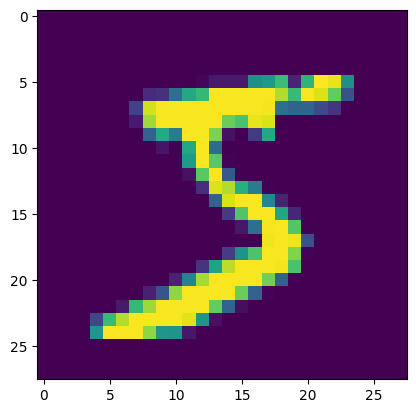

(1, 1, 24, 24)


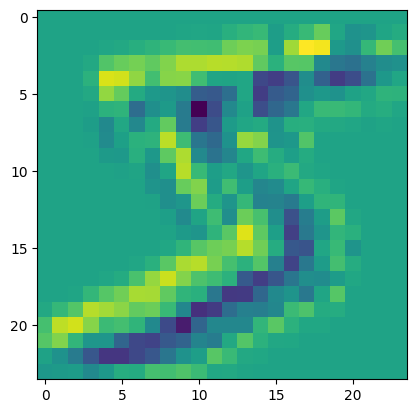

(1, 1, 24, 24)


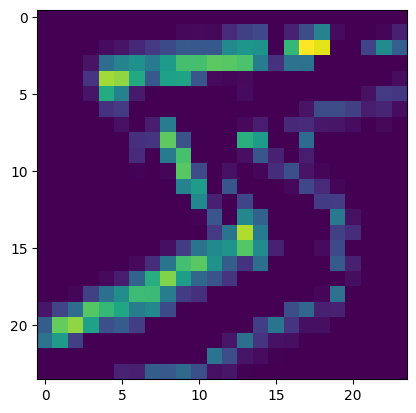

(1, 1, 20, 20)


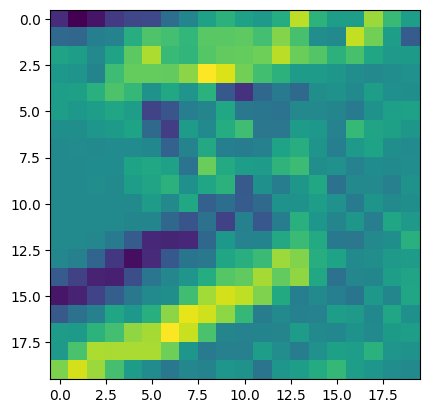

(1, 1, 20, 20)


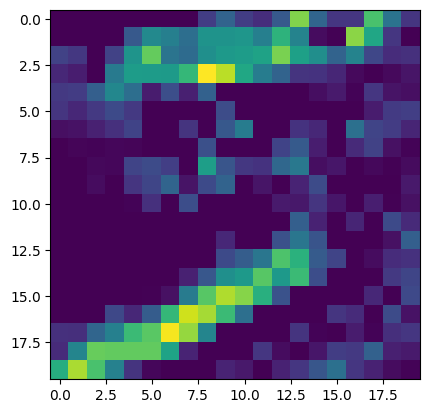

(1, 1, 10, 10)


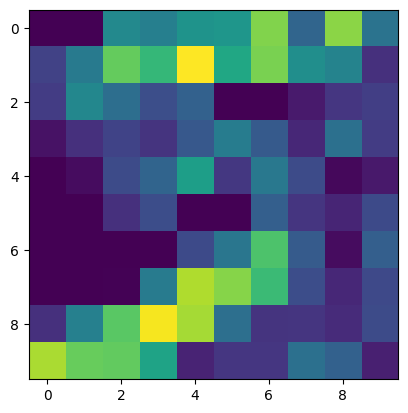

(1, 1, 6, 6)


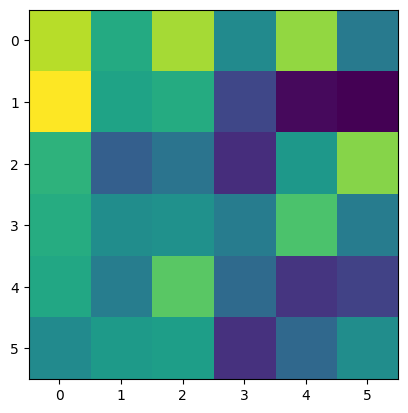

(1, 1, 6, 6)


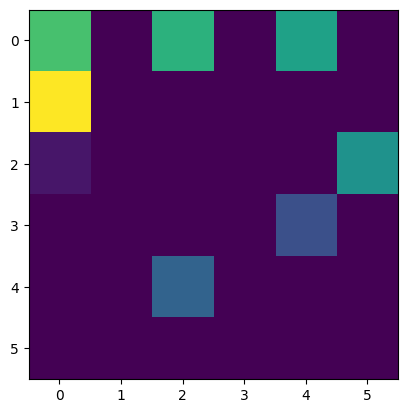

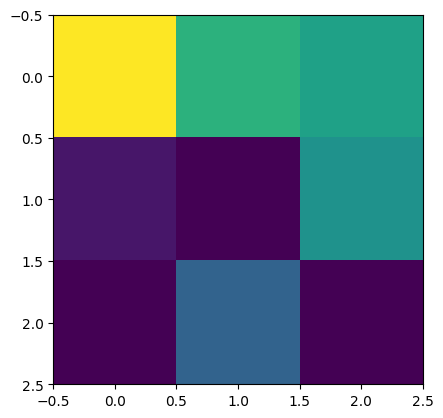

(1, 9)
(1, 100)
(1, 100)
(1, 10)
[[-157.82950505  -98.05964818 -162.6189524  -146.41010681 -128.20346318
    46.96188361  191.71285957  195.28058491  140.08163034  262.3474798 ]]


In [174]:
batch_size = 1
output = train_images[:batch_size].reshape(batch_size, 1, 28, 28)
plt.imshow(output[0][0])
plt.show()

layer = Conv2d(in_channels=1, out_channels=1, kernel_size=5)
output = layer.forward(output)
print(output.shape)
plt.imshow(output[0][0])
plt.show()

layer = ReLU()
output = layer.forward(output)
print(output.shape)
plt.imshow(output[0][0])
plt.show()

layer = Conv2d(in_channels=1, out_channels=1, kernel_size=5)
output = layer.forward(output)
print(output.shape)
plt.imshow(output[0][0])
plt.show()

layer = ReLU()
output = layer.forward(output)
print(output.shape)
plt.imshow(output[0][0])
plt.show()

layer = MaxPool2d(kernel_size=2,stride=2)
output = layer.forward(output)
print(output.shape)
plt.imshow(output[0][0])
plt.show()

layer = Conv2d(in_channels=1, out_channels=1, kernel_size=5)
output = layer.forward(output)
print(output.shape)
plt.imshow(output[0][0])
plt.show()

layer = ReLU()
output = layer.forward(output)
print(output.shape)
plt.imshow(output[0][0])
plt.show()

layer = MaxPool2d(kernel_size=2,stride=2)
output = layer.forward(output)
plt.imshow(output[0][0])
plt.show()


output = output.reshape(batch_size, -1)
print(output.shape)


layer = Linear(in_features=1*3*3, out_features=100)
output = layer.forward(output)
print(output.shape)

layer = ReLU()
output = layer.forward(output)
print(output.shape)

layer = Linear(in_features=100, out_features=10)
output = layer.forward(output)
print(output.shape)
print(output)